# Assignment 2

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network.
For this assignment three methods are developed with the goal of pricing the games:
1. Building a CNN that does not take into consideration that some screenshots belong to the same game.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by stitching the screenshots of a game together to create one large image. This large image is then fed into the CNN. 
1. Building a CNN that takes into consideration that some screenshots belong to the same game by using multiple screenshots of a game as input of a multi-branch CNN with a concatenated layer.

First, some general pre-processing is discussed. This ensures that the same splits will be used for each method. Then, for each method the pre-processing steps are discussed. Then each model with the necessary evaluation criteria is built. Then, based on the the evaluation metric, the best of the three beforementiond methods is selected. Lastly, some interpretability techniques to get insights on the model is given. 

To start, the necessary packages and data are loaded in. The data with for each game the related price and images are included. Additionally, a path is created to where the images are stored on the local device.

In [1]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow


# Set the location of where the images are stored. Adjust to the correct location when running the code!
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'

#  Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

data1 = pd.DataFrame(data) #Make sure that the data has the DataFrame format
data1.head() #print the first 5 rows with data

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,BotMobile,1173,Positive,10,100,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,Just skill shooter 3: 2d edition,199,Positive,11,90,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
2,2816420,2024-02-24,Slime Drop,199,None,None,NaN,"[2D, Arcade, Casual, Clicker, Colorful, Cute, ...",[2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...
3,2815670,2024-02-24,Path to the Creator,299,None,None,NaN,"[2D, Action RPG, Adventure, Character Customiz...",[2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...
4,2776190,2024-02-24,Crowd Control VR,1179,None,None,NaN,"[360 Video, Arcade, Cartoony, Casual, Fantasy,...",[2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...


A key aspect of this assignment is accounting for the fact that a game can have multiple images. Therefore, when splitting the data into the training, validation, test split, this split should be made based on the games and not the seperate images. For this assignment the decision was made to split our data 60/20/20. 

Note that in order to also create a dataset for validation, a train-test split must be performed two times. In the first split the test set is generated. In the second split, the training set from the initial split is used to generate a training and a validation dataset.

In [2]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(data1) * 1)
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)
#print(selected_games) 

from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

Additionally, a preventative measure is taken to detect corrupted images. For this assignment a large zip file needed to be downloaded. Therefore, it did occur that some images became corrupted. This section of code is built to detect these corrupted images. The corrupted images were then mannually removed from the images folder.

In [2]:
from PIL import Image
extensions = []
for fldr in os.listdir(image_location):
    if fldr == '.DS_Store':
        continue
    file_path = os.path.join(image_location, fldr)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if fldr.split('.')[1] not in extensions:
        extensions.append(fldr.split('.')[1])

In the last step of the general pre-processing, some general parameters are defined. This ensures that there is coherence between three models that are proposed in this assignment. 


First, the screenshorts are resized. The original shape of the images have a height of 1080 pixels and a width of 1920 pixels. As discussed later in more detail, this assignment will make use of pre-trained models. These pre-trained models sometimes have constraints on the size of the images that they can process. Therefore, this step already resizes the images to take account of these constraints. 

In [3]:
### Defining some global parameters:

# Resizing the images
reduction = 0.25
width = 224 #1920*reduction
height = 224 #1080*reduction
#height width
image_size = (height, width)

#batch size
batch_size = 64

## Method 1: CNN without accounting for the fact that each game contains multiple images

In this section, the first method of prediciting the price of a game using the image is discussed. In this method the images will be used as input of the CNN the predict the price without accounting for the fact that a game has multiple images. The input of this model is each individual image of the game and the output will be the price.

### Pre-processing

A key aspect of the pre-processing step is normalizing the images and performing some data augmentations (ex. rotations, flips, ...). When performing this pre-processing account must be taken of the fact that there are over 125k images available. This makes it very difficult to manually load in and augment the images. A workaround for this is by using the ImageDataGenerator function in combination with a flow_from_dataframe function (inspired by the following stackoverflow question: https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model). The ImageDataGenerator progressively loads images into the memory while training the model. 

As the flow_from_dataframe function is used, first, a dataset with in first column the screenshot (the feature) and in the second column the price (the target) is created for respectively the training, validation and test set.  

In [4]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

val_label_df = pd.DataFrame(val_data)


# Do the same for the test set
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

test_label_df = pd.DataFrame(test_data)

Next, the ImageDataGenerator is defined. 


In [5]:
# Transormations for the training data
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

# For the validation data
val_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

# for the test set
test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
# here we don't perform any transormations

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size,
                                              batch_size=batch_size)


Found 77551 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25465 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25559 validated image filenames.


Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

## Architecture of the model

In [6]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(height, width, 3))


base_model = EfficientNetV2S(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    pooling=None,
    include_preprocessing = False #because the data is already normalized
)
#base_model.summary()

# Freeze the base model
base_model.trainable = False

x = base_model(inputs, training=False)
# Make the last 6 layers trainable
#for layer in base_model.layers[:-6]:
#    layer.trainable = False

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1, name="top_dropout")(x)
outputs = layers.Dense(1, activation = "exponential", name="prediction")(x) # No activation is function is used, because we are interested in the numeric value without any transformation
# did not use a ReLu activation function because this can only be used in the hidden layers.

model = keras.Model(inputs, outputs)



## Prevention of overfitting

Cannot use MAPE because there are prices equal to zero => will not work
How we are preventing overfitting:
- keeping track of a validation set and early stopping if the validation set has reached its minimum level (so the delta does not increase anymore)
- Dropout
- Batch normalization

Loss function: using rmse 
This depends on your loss function. In many circumstances it makes sense to give more weight to points further away from the mean--that is, being off by 10 is more than twice as bad as being off by 5. In such cases RMSE is a more appropriate measure of error. https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error 



As mentioned above, Cyclical Learning Rates enables our learning rate to oscillate back and forth between a lower and upper bound.

So, why bother going through all the trouble?

Why not just monotonically decrease our learning rate, just as we’ve always done?

The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.

Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.

Instead, we can use Cyclical Learning Rates to oscillate our learning rate between upper and lower bounds, enabling us to:

Have more freedom in our initial learning rate choices.
Break out of saddle points and local minima.
In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

In [8]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam, SGD

#set the CLR options
clr_step_size = int(4 * (len(train_generator)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 1e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.001)

# Adding an early stopping mechanism
EarlyStoppinng = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    start_from_epoch=5,
)

model.compile(optimizer=opt, loss='mean_squared_error', metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")
# Loss function: the parameter that is used to optimize the model, i.e. the loss function is minimized by the model
# Metric: what is used to evaluate the model performance (this can be used to compare different models)



Model is compiled


In [9]:
# Fitting the model
# fit the model
history = model.fit(
    train_generator,
    callbacks=[ EarlyStoppinng, clr_triangular],
    steps_per_epoch=train_generator.n//batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps = val_generator.n//batch_size
)

Epoch 1/6


2024-04-29 00:13:44.901937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-29 00:13:44.943553: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1211/1211 [==============================] - ETA: 0s - loss: 45013844.0000 - mean_absolute_error: 1132.0006

2024-04-29 01:03:42.680987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1211/1211 [==============================] - 3969s 3s/step - loss: 45013844.0000 - mean_absolute_error: 1132.0006 - val_loss: 67010644.0000 - val_mean_absolute_error: 1206.6251
Epoch 2/6
1211/1211 [==============================] - 4121s 3s/step - loss: 44936104.0000 - mean_absolute_error: 1130.7448 - val_loss: 67011684.0000 - val_mean_absolute_error: 1206.6664
Epoch 3/6
1211/1211 [==============================] - 4021s 3s/step - loss: 44935624.0000 - mean_absolute_error: 1130.7015 - val_loss: 63038120.0000 - val_mean_absolute_error: 1194.1492
Epoch 4/6
1211/1211 [==============================] - 4127s 3s/step - loss: 44935844.0000 - mean_absolute_error: 1130.8405 - val_loss: 67006664.0000 - val_mean_absolute_error: 1205.9327
Epoch 5/6
1211/1211 [==============================] - 4004s 3s/step - loss: 44935560.0000 - mean_absolute_error: 1130.7454 - val_loss: 67008784.0000 - val_mean_absolute_error: 1206.1322
Epoch 6/6
1211/1211 [==============================] - 3999s 3s/step - loss

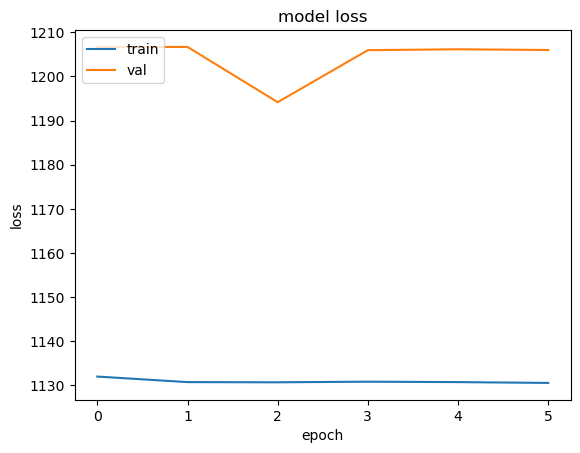

In [12]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

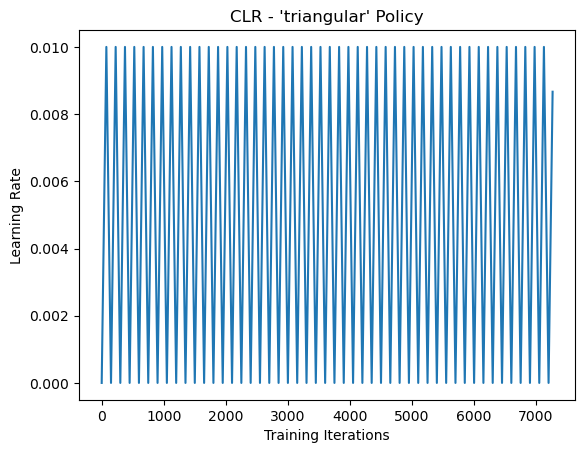

In [13]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


In [90]:
# Evaluate model
loss, mean_absolute_percentage_error = model.evaluate(test_generator, steps = test_generator.n//batch_size)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - loss: 1164.0009 - mean_absolute_error: 1164.0062


NameError: name 'mean_absolute_error' is not defined

In [96]:
print("Test MAE:", mean_absolute_percentage_error)

Test MAE: 1099.7979736328125


In [91]:
test_label_df.head(20)

,screenshot,price
0,2619790_ss_49e82bd65701112321008fb766f1cbd1f28...,499
1,2619790_ss_812ae723120b7e3f3723331e736d9bd7968...,499
2,2619790_ss_8aa4bfae1466ab5aec6f163a7a2048ff31b...,499
3,2619790_ss_96f9d1488f6e0c86c3f99a9a1732e7c1400...,499
4,2619790_ss_bb35362a034ccb7c7cf910e09f55db60969...,499
5,2619790_ss_c0eacae1f6dff680103364f69afcbc8003c...,499
6,1876880_ss_1326783826956c817f429691b4aed9f2acd...,1849
7,1876880_ss_201c96dd0cb2a8a06f2985fc30cb8168b23...,1849
8,1876880_ss_226045df856c7e0af50dc55a38749218ba5...,1849
9,1876880_ss_29067ed3a902ca11ada83fe431262f1caf4...,1849


Give the predicted price for a game


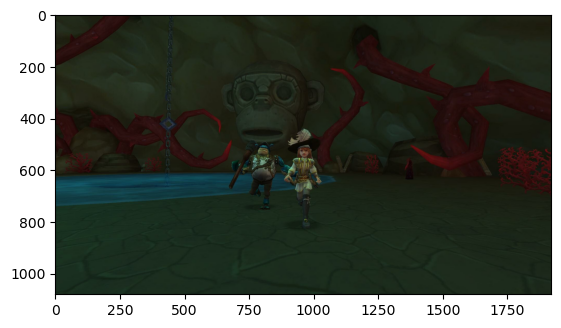

AttributeError: module 'keras' has no attribute 'ops'

In [7]:
# Define the image location
number = 100
#print(test_label_df.loc[number, "screenshot"])
filename = '620620_ss_01fe128c1e30f3cc9cee30fa4bbdb7f60e9abe67.1920x1080.jpg'
#test_label_df.loc[number, "screenshot"]
#

# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(1080, 1920))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])




In [22]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

_________________________________________________________________________________________________________________________